In [1]:
%load_ext autoreload

In [2]:
%autoreload 0

import os
import os.path
import pandas as pd
import numpy as np
import datetime
import matplotlib
import pickle
import json
import googlemaps
# Installing LightGBM on HighSierra: https://stackoverflow.com/questions/44937698/lightgbm-oserror-library-not-loaded
import lightgbm as lgb
import plotly
import plotly.plotly as py
from plotly.graph_objs import *
import seaborn as sns
from matplotlib import pyplot as plt
import codecs
import graphviz
from multiprocessing import Pool, current_process

from sklearn.metrics import accuracy_score, log_loss, mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (14.0, 7.0)

%autoreload 2

from feature_encrichment import basic_enrichment
from compute_util import load_data, parallel_df, save_df, rmse, parallel_col_df

## Global Config

In [3]:
DATA_PATH = '/Users/ilaif/Desktop/data/avito'
HELPER_DATA_PATH = './helper_data'

## Load Data

In [5]:
train, _ = load_data(DATA_PATH)

Let's look at the raw columns we have in train.csv:

In [6]:
train.columns

Index(['item_id', 'user_id', 'region', 'city', 'parent_category_name',
       'category_name', 'param_1', 'param_2', 'param_3', 'title',
       'description', 'price', 'item_seq_number', 'activation_date',
       'user_type', 'image', 'image_top_1', 'deal_probability'],
      dtype='object')

## Feature enrichment

In [7]:
def parallel_func(df):
    return basic_enrichment(df, helper_data_path=HELPER_DATA_PATH)
train = parallel_df(train, parallel_func, num_partitions=14)
print('All processes finished.')

ForkPoolWorker-1: Enriching input dataframe...
ForkPoolWorker-1: Adding missing values as features enrichment...
ForkPoolWorker-1: Adding datetime enrichment...
ForkPoolWorker-1: Adding geocoding enrichment...
ForkPoolWorker-1: Adding basic language enrichment...
ForkPoolWorker-2: Enriching input dataframe...
ForkPoolWorker-2: Adding missing values as features enrichment...
ForkPoolWorker-2: Adding datetime enrichment...
ForkPoolWorker-2: Adding geocoding enrichment...
ForkPoolWorker-3: Enriching input dataframe...
ForkPoolWorker-3: Adding missing values as features enrichment...
ForkPoolWorker-3: Adding datetime enrichment...
ForkPoolWorker-2: Adding basic language enrichment...
ForkPoolWorker-3: Adding geocoding enrichment...
ForkPoolWorker-3: Adding basic language enrichment...
ForkPoolWorker-4: Enriching input dataframe...
ForkPoolWorker-4: Adding missing values as features enrichment...
ForkPoolWorker-4: Adding datetime enrichment...
ForkPoolWorker-4: Adding geocoding enrichment..

## Learning

In [8]:
results = {}

In [9]:
train.columns

Index(['item_id', 'user_id', 'region', 'city', 'parent_category_name',
       'category_name', 'param_1', 'param_2', 'param_3', 'title',
       'description', 'price', 'item_seq_number', 'activation_date',
       'user_type', 'image', 'image_top_1', 'deal_probability',
       'has_description', 'has_price', 'has_params', 'has_image', 'year',
       'month', 'day', 'lat', 'lng', 'description_len', 'title_len',
       'title_word_count', 'description_word_count', 'params_total_word_count',
       'title_capital_letters_ratio', 'description_capital_letters_ratio',
       'parent_category_name_en', 'category_name_en', 'param_1_en',
       'param_2_en', 'param_3_en', 'user_ads_count'],
      dtype='object')

#### Preparing data for Learn and Test

In [12]:
categorical_cols = [
    'user_id', 
    'region', 
    'city', 
    'parent_category_name', 
    'category_name', 
    'has_description',
    'has_price',
    'has_params',
    'has_image',
]
numerical_cols = [
    'item_seq_number', 
    'month', 
    'price',
    'title_word_count',
    'description_word_count',
    'params_total_word_count',
    'user_ads_count',
    'title_capital_letters_ratio',
    'description_capital_letters_ratio',
    'image_top_1',
]
feature_list = categorical_cols + numerical_cols

X_df = train[feature_list]
y_df = train['deal_probability']
train_num = X_df.shape[0]
X = pd.DataFrame(X_df[:train_num]).fillna(0).values
y = y_df[:train_num].values #.apply(separate_to_bins, axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### Encoding Labels

In [13]:
les = []
for i in range(X.shape[1]):
    le = preprocessing.LabelEncoder()
    le.fit(X[:, i])
    les.append(le)
    X_train[:, i] = le.transform(X_train[:, i])
    X_test[:, i] = le.transform(X_test[:, i])

#### Naive random prediction

In [14]:
y_pred = np.random.randint(1, size=y_test.shape[0])
res = rmse(y_pred, y_test)
print(res)
results['naive'] = { 'rmse': res }

0.29465919592925616


#### Linear Regression

In [15]:
l = LinearRegression()
l.fit(X_train, y_train)
y_pred = l.predict(X_test)
res = rmse(y_pred, y_test)
print(res)
results['linear_regression'] = { 'rmse': res }

/Users/ilaif/.virtualenvs/ds/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning:

internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.



0.252108938196982


#### Random Forest Regressor

In [16]:
r = RandomForestRegressor(n_estimators=25, max_depth=10, n_jobs=-1)
r.fit(X_train, y_train)
y_pred = r.predict(X_test)
res = rmse(y_pred, y_test)
print(res)
results['random_forest_regressor'] = { 'rmse': res }

0.2355411760741498


#### One-hot encoding

#### Linear Regression (OHE)

#### Random Forest Regressor (OHE)

In [17]:
def ohe():
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(X_train)
    enc.fit(X_test)
    X_train_one_hot = enc.transform(X_train)
    X_test_one_hot = enc.transform(X_test)
def lrohe():
    l.fit(X_train_one_hot, y_train)
    y_pred = l.predict(X_test_one_hot)
    res = rmse(y_pred, y_test)
    print(res)
    results = {'linear_regression_ohe': { 'rmse': res } }
def rfrohe():
    r.fit(X_train_one_hot, y_train)
    y_pred = r.predict(X_test_one_hot)
    res = rmse(y_pred, y_test)
    print(res)
    results = {'random_forest_regressor_ohe': { 'rmse': res } }

In [18]:
# ex_col = ['item_id', 'user_id','deal_probability', 'title', 'description', 'image']
# col = [c for c in train.columns if c not in ex_col]

# x1, x2, y1, y2 = model_selection.train_test_split(train[col], train.deal_probability.values, test_size=0.20, random_state=19)
# params = {'learning_rate': 0.05, 'boosting': 'gbdt', 'objective': 'regression', 'metric': ['auc','rmse'], 'is_training_metric': True, 'seed': 19, 'num_leaves': 64, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'bagging_freq': 5}
# model2 = lgb.train(params, lgb.Dataset(x1, label=y1), 3000, lgb.Dataset(x2, label=y2), verbose_eval=200, early_stopping_rounds=100)
# test['deal_probability'] = model2.predict(test[col], num_iteration=model2.best_iteration)
# test['deal_probability'] = test['deal_probability'].clip(0., 1.)
# test[['item_id','deal_probability']].to_csv('submission.csv', index=False)

#### LightGBM

* https://github.com/Microsoft/LightGBM/tree/master/examples/python-guide
* https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

In [19]:
# TODO: Fitting features
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

In [20]:
def categorical_indices(df, categorical_cols):
    return [i for i, col in enumerate(df.columns) if col in categorical_cols]

categorical_features = categorical_indices(X_df, categorical_cols)
# categorical_feature=categorical_features
lgb_train = lgb.Dataset(X_train, 
                      label=y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    'learning_rate': 0.05,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'sub_feature': 0.5,
    'min_data': 50,
    #'max_depth': 10,
    'max_depth' : -1,
    'is_training_metric': True, 
    'seed': 19, 
    'num_leaves': 64, 
    'feature_fraction': 0.9, 
    'bagging_fraction': 0.8, 
    'bagging_freq': 5,
    'verbose': 0,
    
    'nthread': 7,
    'max_bin': 512, 
    'subsample_for_bin': 200,
    'subsample': 1, 
    'subsample_freq': 1, 
    'colsample_bytree': 0.8, 
    'reg_alpha': 5, 
    'reg_lambda': 10,
    'min_split_gain': 0.5, 
    'min_child_weight': 1, 
    'min_child_samples': 5, 
    'scale_pos_weight': 1,    
}

In [21]:
def train_lgb(my_params, my_lgb_train, my_lgb_test):
    evals_result = {}

    clf = lgb.train(my_params, 
                my_lgb_train, 
                num_boost_round=100,
                valid_sets=[my_lgb_train, my_lgb_test],
                feature_name=feature_list,
                categorical_feature=categorical_features,
                evals_result=evals_result,
                verbose_eval=10)
    
    return clf, evals_result

In [22]:
def test_lgb(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    res = rmse(y_pred, y_test)
    print(res)
    return res

In [26]:
clf, evals_result = train_lgb(params, lgb_train, lgb_test)

[10]	training's rmse: 0.245616	valid_1's rmse: 0.245324
[20]	training's rmse: 0.239455	valid_1's rmse: 0.239162
[30]	training's rmse: 0.236705	valid_1's rmse: 0.236434
[40]	training's rmse: 0.235181	valid_1's rmse: 0.234964
[50]	training's rmse: 0.234268	valid_1's rmse: 0.234094
[60]	training's rmse: 0.233573	valid_1's rmse: 0.23346
[70]	training's rmse: 0.233172	valid_1's rmse: 0.233115
[80]	training's rmse: 0.232848	valid_1's rmse: 0.232839
[90]	training's rmse: 0.232567	valid_1's rmse: 0.232611
[100]	training's rmse: 0.232276	valid_1's rmse: 0.232384


In [27]:
results['lgbm'] = { 'rmse': test_lgb(clf, X_test, y_test) }

0.23238366019350354


In [28]:
print(json.dumps(results, indent=2))

{
  "naive": {
    "rmse": 0.29465919592925616
  },
  "linear_regression": {
    "rmse": 0.252108938196982
  },
  "random_forest_regressor": {
    "rmse": 0.2355411760741498
  },
  "lgbm": {
    "rmse": 0.23238366019350354
  }
}


In [29]:
def analyze_lgbm_result():
    print('Plot metrics during training...')
    ax = lgb.plot_metric(evals_result, metric='rmse')
    plt.show()

    print('Plot feature importances...')
    ax = lgb.plot_importance(clf, max_num_features=10)
    plt.show()

    print('Plot 84th tree...')  # one tree use categorical feature to split
    ax = lgb.plot_tree(clf, tree_index=83, figsize=(20, 8), show_info=['split_gain'])
    plt.show()

    print('Plot 84th tree with graphviz...')
    graph = lgb.create_tree_digraph(clf, tree_index=83, name='Tree84')
    graph.render(view=True)

Plot metrics during training...


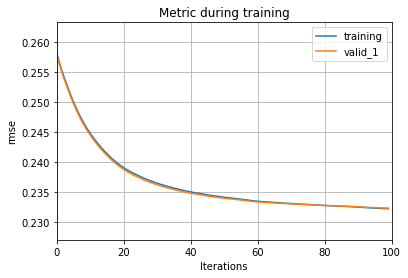

Plot feature importances...


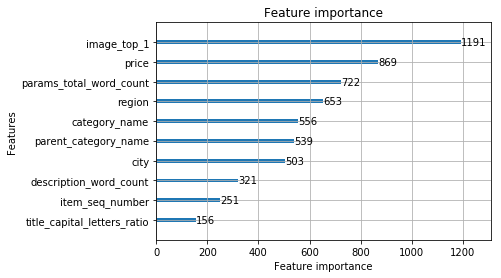

Plot 84th tree...


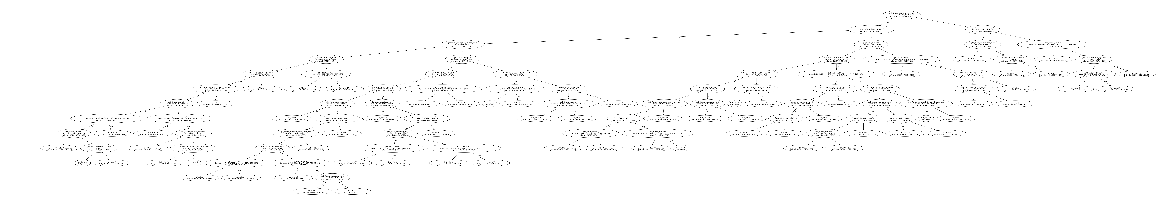

Plot 84th tree with graphviz...


In [30]:
analyze_lgbm_result()

* TODO: Balancing data: https://www.kaggle.com/pranav84/lightgbm-fixing-unbalanced-data-lb-0-9680/code

https://www.kaggle.com/garethjns/microsoft-lightgbm-with-parameter-tuning-0-823

In [31]:
# Create parameters to search
grid_params = {
    'learning_rate': [0.005],
    'n_estimators': [8,16,24],
    'num_leaves': [6,8,12,16],
    'boosting_type' : ['gbdt'],
    'objective' : ['regression'],
    'random_state' : [501], # Updated from 'seed'
    'colsample_bytree' : [0.64, 0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
}

In [ ]:
def hyperparam_tuner(grid_params, X_train, X_test):
    # Create classifier to use. Note that parameters have to be input manually, not as a dict!
    mdl = lgb.LGBMRegressor(
        boosting_type= 'gbdt', 
        objective = 'regression', 
        n_jobs = 1, # Updated from 'nthread' 
        silent = False,
        max_depth = params['max_depth'],
        max_bin = params['max_bin'], 
        subsample_for_bin = params['subsample_for_bin'],
        subsample = params['subsample'], 
        subsample_freq = params['subsample_freq'], 
        min_split_gain = params['min_split_gain'], 
        min_child_weight = params['min_child_weight'], 
        min_child_samples = params['min_child_samples'], 
        scale_pos_weight = params['scale_pos_weight']
    )

    # To view the default model params:
    mdl.get_params().keys()

    # Create the grid
    grid = GridSearchCV(mdl, gridParams, verbose=1, cv=4, n_jobs=-1)
    # Run the grid
    grid.fit(X_train, y_train)

    # Print the best parameters found
    print(grid.best_params_)
    print(grid.best_score_
          
    return grid.best_params_

In [ ]:
# best_params = hyperparam_tuner(grid_params, X_train, X_test)
# tuned_params = params.copy()
# tuned_params.update(best_params)

In [ ]:
# clf, tuned_evals_result = train_lgb(tuned_params, lgb_train, lgb_test)